In [74]:
from dataclasses import dataclass
from typing import List, Tuple
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as st
from statistics import NormalDist

@dataclass
class NormalDistribution:
    mean: float
    std: float
    
@dataclass
class Part:
    
    type: str
    sub_part_name: str
    sensor: str
    signals: List   # Signal is numpy array of (500,3) with [frequency, Z, X]

In [75]:

def load_part_data(part_type: str) -> List[Part]:
    
    parts = []
    for part_dir in os.listdir(f'psig_matcher/data/{part_type}'):
        
        sensor = part_dir[1:]
        measurement_files = glob.glob(f'psig_matcher/data/{part_type}/{part_dir}/*.npy')
        measurements = [np.load(f) for f in measurement_files]
        parts.append(Part(part_type, part_dir, sensor, measurements))
    
    return parts

con_parts = load_part_data('CON')
#conlid_parts = load_part_data('CONLID') # Need to handle the damage files
lid_parts = load_part_data('LID')

In [76]:
import dataclasses


def limit_deminsionality(parts: List[Part], frequeny_indexes: List[int]) -> List[Part]:
    """Use only a subset of the frequencies for the analysis. This effectivley transforms the 
    500 dimension multivariant distribution to a n-dimentional distribution where n is the
    length of the frequency_indexes.
    
    Further, this assumes use of the X axis"""
    
    return [
        dataclasses.replace(part, signals=[[signal[index][1] for index in frequeny_indexes] for signal in part.signals])
        for part in parts]

In [77]:
def estimate_normal_dist(x: List[float]) -> NormalDistribution:
    """Estimate the normal distribution for the given data
    
    TODO (henry): Expand this using https://handbook-5-1.cochrane.org/chapter_7/7_7_3_2_obtaining_standard_deviations_from_standard_errors_and.htm#:~:text=The%20standard%20deviation%20for%20each,should%20be%20replaced%20by%205.15.
    """
    return NormalDistribution(np.mean(x, axis=0), np.std(x))

    
    

In [82]:
def plot_single_distributions(pdfs: List[NormalDistribution], labels: List[str], title: str):
    """ pdfs is a list of tuples of (mean, std) for each distribution."""
    
    for pdf, label in zip(pdfs, labels):
        
        x = np.linspace(pdf.mean - 3* pdf.std, pdf.mean + 3* pdf.std, 100)
        plt.plot(x, norm.pdf(x, pdf.mean, pdf.std), label=label)
    
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

In [79]:
def find_overlap(normal_d_1: NormalDistribution, normal_d_2: NormalDistribution) -> float:
    """Finds the overlap between two distributions."""
    
    return NormalDist(mu=normal_d_1.mean, sigma=normal_d_1.std).overlap(NormalDist(mu=normal_d_2.mean, sigma=normal_d_2.std))


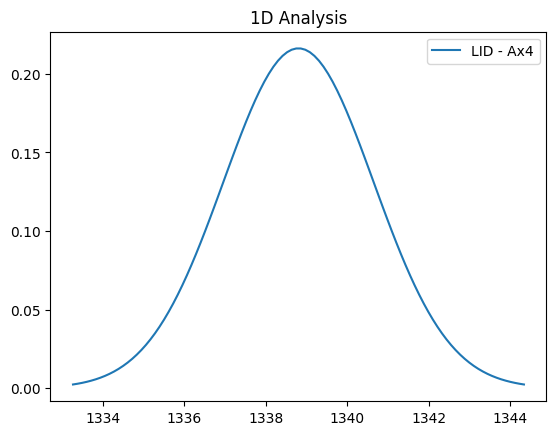

Bx5 vs Cx6: Ttest_indResult(statistic=array([[ 1.15470054, -2.02582944,  2.02358321],
       [ 1.16303591, -2.1517414 ,  2.15053623],
       [ 1.17139044, -2.27433319,  2.27385946],
       ...,
       [ 2.66666196, -3.21443314,  3.22967384],
       [ 2.66666549, -3.24116726,  3.24672852],
       [ 2.66666667, -3.28320681,  3.28097434]]), pvalue=array([[0.26516824, 0.05979335, 0.0600472 ],
       [0.26186794, 0.04703423, 0.04714348],
       [0.25859136, 0.03706652, 0.03710094],
       ...,
       [0.01688502, 0.00541103, 0.00524037],
       [0.0168849 , 0.0051152 , 0.0050557 ],
       [0.01688486, 0.00468201, 0.00470408]]))
Bx5 vs Ax4: Ttest_indResult(statistic=array([[ 1.15470054, -1.28281495,  1.28439384],
       [ 1.16303591, -1.32177174,  1.32224255],
       [ 1.17139044, -1.33103879,  1.32765013],
       ...,
       [ 2.66666196, -3.54560802,  3.00640157],
       [ 2.66666549, -3.52795665,  3.00274914],
       [ 2.66666667, -3.54935769,  3.02669658]]), pvalue=array([[0.26516824, 0.

/var/folders/vm/kv5c83xd7zng0b6jhjd95w_w0000gn/T/ipykernel_98654/183854304.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(f"{parts[i].sub_part_name} vs {parts[k].sub_part_name}: {st.ttest_ind(parts[i].signals, parts[k].signals)}")


In [84]:
def perform_1d_analysis(parts: List[Part]):
    
    single_d_parts = limit_deminsionality(parts, [0])
    pdfs = [estimate_normal_dist(part.signals) for part in single_d_parts]
    plot_single_distributions(pdfs[-1:], [f"{part.type} - {part.sub_part_name}" for part in single_d_parts[-1:]], f'1D Analysis')
    
    for i in range(len(pdfs)):
        for k in range(i+1, len(pdfs)):
            # Currently this method redundantly counts overlaps that may have already been accounted for. 
            # If A and B overlap on the edge of B, but C also overlaps on the edge of B, we're double
            # counting that overlap. Maybe we want to do this? 
            print(f"{parts[i].sub_part_name} vs {parts[k].sub_part_name}: {st.ttest_ind(parts[i].signals, parts[k].signals)}")
    
    

#perform_1d_analysis(con_parts)
perform_1d_analysis(lid_parts)
